In [ ]:
!pip install alpha_vantage

     |████████████████████████████████| 1.3 MB 7.7 MB/s 
     |████████████████████████████████| 294 kB 57.4 MB/s 
     |████████████████████████████████| 142 kB 48.4 MB/s 


**Stuff to try based on possible problems**
1. The problem is that there is not enough data for LSTM
  - change the test-training test split from 0.8 to 0.9
  - add the rest of the data instead of just using the first 1000 days
  - (UNFIXABLE) There are other metrics that are needed as inputs
2. The problem is that the parameters are arbitrary and not optimized
  - change the number of days being used for prediction (i.e. change num_days_used)
  - change the parameters on the layers
3. The problem is that the layers being used are too arbitrary
  - add/subtract layers based on research
  - change the layer types
4. The problem is that the scaling is off
  - Check out the scaling factor problem

**PRIORITY #1: GET MULTIOUTPUT WORKING / FIGURE OUT BACKPROP**

**GAMEPLAN:** For the next sprint, spend around 1.5 hours on trying out the different solutions outlined, but afterwards move on to adapting the current code to accomodate multiple outputs. More specifically, change the model so that there are now multiple branches for the output.





In [ ]:
import numpy as np 
import pandas as pd
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

from alpha_vantage.timeseries import TimeSeries

**Getting Apple's stock price history using AlphaVantage**



In [ ]:
# Configuring AlphaVantage stuff

# Storing my API key
api_key = open('AlphaVantage_API_key.txt').read()

# Creating a function to save datasets into csv's
def save_dataset(symbol):

    ts = TimeSeries(api_key, output_format='pandas')
    data, meta_data = ts.get_daily_adjusted(symbol, outputsize='full')
    data.to_csv(f'./{symbol}_daily_adjusted.csv')


In [ ]:
# Downloading AAPL's stock price history 
save_dataset('AAPL')
df = pd.read_csv('/content/AAPL_daily_adjusted.csv')

**Preprocessing Apple's data**

,1. open,2. high,3. low,5. adjusted close,6. volume
date,,,,,
2017-08-21,37.576490,37.669536,37.006305,37.507301,26145653.0
2017-08-22,37.750654,38.172942,37.700552,38.120454,21297812.0
2017-08-23,37.951062,38.285075,37.905731,38.168170,19198189.0
2017-08-24,38.275532,38.349492,37.827000,37.998778,19029621.0
2017-08-25,38.089439,38.306547,37.998778,38.139541,25015218.0
...,...,...,...,...,...
2021-08-04,147.048632,147.567851,146.060120,146.729113,56368271.0
2021-08-05,146.759068,147.617775,145.950286,146.838948,46397674.0
2021-08-06,146.350000,147.110000,145.630000,146.140000,54126813.0


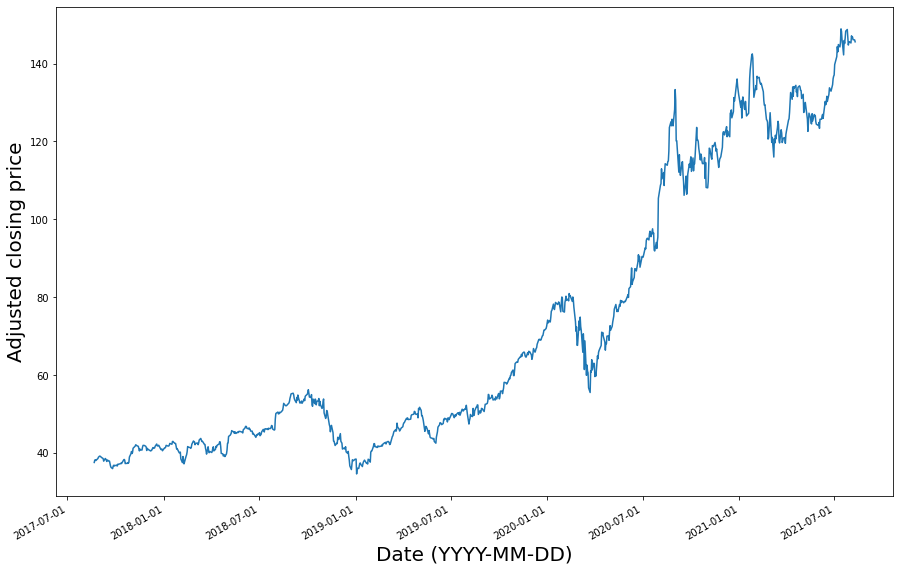

In [ ]:
# Creating a dataframe for data for the past 1000 days (last day is on 05/28/2021)
# that's been adjusted based on the values from close / adjusted close. 
# NOTE: 'Adjusted close' has a specific meaning, which causes the values
# from close / adjusted close to not necessarily reflect the stock split.
# For example, this value can be 4.202 sometimes even if the stock split is 4:1.
# Thus, the data may not be accurate but can still be used for a preliminary investigation.

df_1000 = df[:1000].iloc[::-1]
adjustment_factor = df_1000['4. close'] / df_1000['5. adjusted close']
df_1000['1. open'] = df_1000['1. open'] / adjustment_factor
df_1000['2. high'] = df_1000['2. high'] / adjustment_factor
df_1000['3. low'] = df_1000['3. low'] / adjustment_factor
df_1000['old close'] = df_1000['4. close']
df_1000['4. close'] = df_1000['4. close'] / adjustment_factor

df_1000['date'] = pd.to_datetime(df_1000['date'], yearfirst=True, format='%Y-%m-%d')
# display(df_1000, df_1000.info())
# Plotting the adjusted close vs. time
# _______________________________________________
fig = plt.figure(figsize=(15, 10))
plt.xlabel('Date (YYYY-MM-DD)', fontsize=20)
plt.ylabel('Adjusted closing price', fontsize=20)

dates = df_1000['date']
y_prices = df_1000['5. adjusted close']

ax = plt.gca()
formatter = mdates.DateFormatter("%Y-%m-%d")
ax.xaxis.set_major_formatter(formatter)

plt.plot(dates, y_prices)
ax.xaxis_date()
fig.autofmt_xdate()
# _______________________________________________

# Creating a new dataframe with just the inputs I want
df_1000 = df_1000[['1. open', '2. high', '3. low', '5. adjusted close', '6. volume']].set_index(dates)

display(df_1000)

In [ ]:
from sklearn import preprocessing 
# Creating a variable to control how many days in the past to use as data for a single prediction
num_days_used = 7

# Normalising data using MinMax
# df_1000 turns into a 2D-array, now named arr_1000
minmax_scaler = preprocessing.MinMaxScaler()
arr_1000 = minmax_scaler.fit_transform(df_1000)

display(arr_1000)

array([[0.02266681, 0.01971606, 0.02209114, 0.02579718, 0.04601971],
       [0.02419424, 0.02411801, 0.0282367 , 0.03115837, 0.03092893],
       [0.02595184, 0.02509854, 0.03005297, 0.03157558, 0.02439304],
       ...,
       [0.97662179, 0.97670046, 0.9836414 , 0.97564193, 0.13312192],
       [0.97530627, 0.97311528, 0.98266767, 0.97520474, 0.11687849],
       [0.9774111 , 0.98194706, 0.9807202 , 0.97092036, 0.17949233]])

In [ ]:
# Storing the number of data points in the array
num_data = len(arr_1000)

# Creating a numpy array that contains the past num_days_used days' open, high, low, close, and volume
# For example, when num_days_used = 30, each element in the list contains those values for the previous 30 days
# This is equivalent to the input / X-values to be used 
data_used = np.array([arr_1000[i : i + num_days_used].copy() for i in range(num_data - num_days_used)])

# Creating a numpy array that contains the value(s) to predict
# Currently, trying to fit the 4 outputs
data_to_predict = np.array(arr_1000[(num_days_used):, :4])
# data_to_predict = np.expand_dims(data_to_predict, -1)

# Creating a dates array for the dates that were used by data_used
dates_used = df_1000.index[num_days_used:num_data]

# Storing the scaler object for prediction later
# NOTE: I'm concerned that this min_max scaler will be inaccurate because of the
# scale's dependence on the max value of the training set
y_normaliser = preprocessing.MinMaxScaler()
y_normaliser.fit(df_1000[['1. open', '2. high', '3. low', '5. adjusted close']].to_numpy()[num_days_used:])

# data_used.shape
# data_to_predict.shape[0]
# display(data_to_predict)
display(arr_1000.shape, data_used.shape,data_to_predict.shape, dates_used.shape)

(1000, 5)

(993, 7, 5)

(993, 4)

(993,)

In [ ]:
from numpy import random
np.random.seed(18)
# Fraction of data that's used as the training set
train_split = 0.8
data_size = data_used.shape[0]
num_features = data_used.shape[2]
train_size = int(data_size * train_split)
test_size = data_size - train_size
random_indices = np.random.choice(data_size, size = train_size, replace=False)

# Creating a mask / an array of booleans where the random_indices are false
# Acts as a filter to create the test set based on which indices were selected
# to be part of the training set 
mask = np.ones(data_used.shape[0], dtype=bool)
mask[random_indices] = False

# Splitting the dataset up into train and test sets
X_train = data_used[random_indices, :, :]
y_train = data_to_predict[random_indices, :]
dates_train = dates_used[random_indices]
X_test = data_used[mask, :, :]
y_test = data_to_predict[mask, :]
dates_test = dates_used[mask]

unscaled_y_test = df_1000[['1. open', '2. high', '3. low', '5. adjusted close']].to_numpy()[(num_days_used):][mask, :]

display("X_train shape:", X_train.shape, "y_train shape:", y_train.shape, 
        "X_test shape:", X_test.shape, "y_test shape:", y_test.shape, 
        "unscaled_y_test shape:", unscaled_y_test.shape)
# display(unscaled_y_test, y_normaliser.inverse_transform(y_test))
# display(mask.shape, data_used.shape, data_used[random_indices, :, :].shape, data_used[mask, :, :].shape)

# NOTE: inverse_transforming the normalised y_test returns similar values to the original
# adjusted closing price, but are NOT EXACT


# ###################
# # Trying a model that doesn't randomize training set, but is instead "linear"
# # RESULT: A lot worse than randomized training set, which is weird because 
# # on Multi_output_2, the predictions are a lot better and comparable to model with randomized data
# # Fraction of data that's used as the training set
# train_split = 0.8
# n = int(data_to_predict.shape[0] * train_split)

# # Splitting the dataset up into train and test sets
# X_train = data_used[:n]
# y_train = data_to_predict[:n]

# X_test = data_used[n:]
# y_test = data_to_predict[n:]

# unscaled_y_test = df_1000[['1. open', '2. high', '3. low', '5. adjusted close']].to_numpy()[(num_days_used):][n:]

# num_features = data_used.shape[2]
# dates_test = dates_used[n:]

# display(X_train.shape, y_train.shape, X_test.shape, y_test.shape, unscaled_y_test.shape)
# # display(unscaled_y_test, y_normaliser.inverse_transform(y_test))

# # NOTE: inverse_transforming the normalised y_test returns similar values to the original
# # adjusted closing price, but are NOT EXACT

'X_train shape:'

(794, 7, 5)

'y_train shape:'

(794, 4)

'X_test shape:'

(199, 7, 5)

'y_test shape:'

(199, 4)

'unscaled_y_test shape:'

(199, 4)

**Building the model**

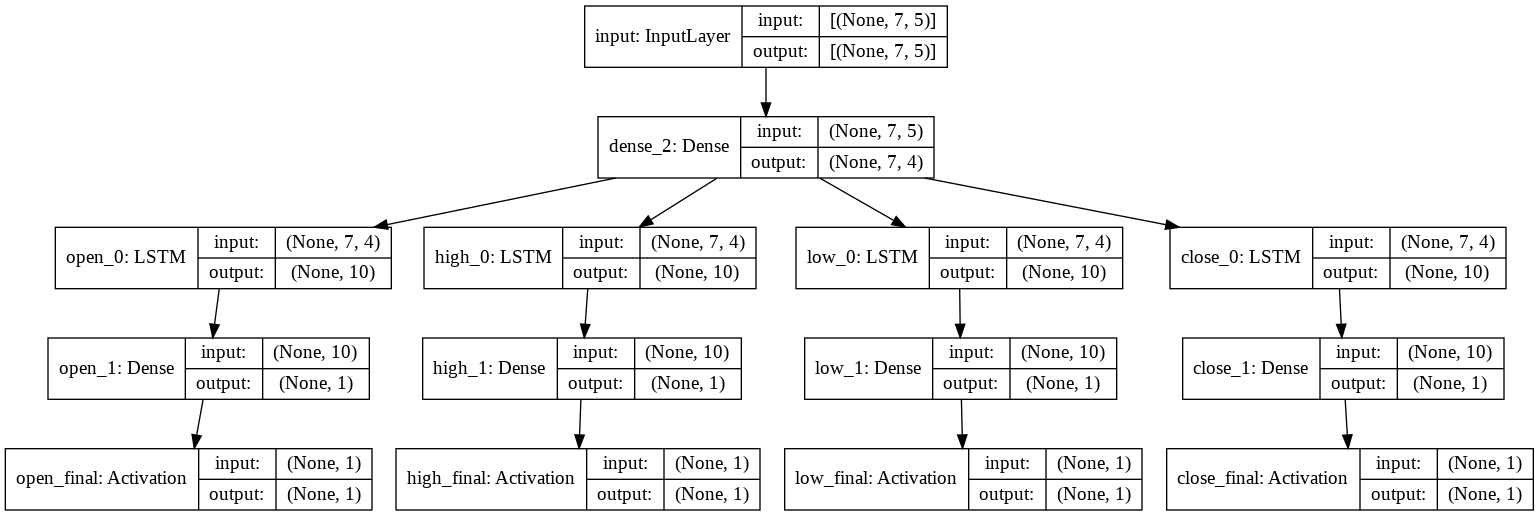

In [ ]:
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate, Flatten
from keras import optimizers

# Creating the input layer, whose shape is (num_days_used, num_features) because it is
# the open, high, low, close, volume for the past num_days_used days 
input = Input(shape=(num_days_used, num_features), name = 'input')

# Adding the rest of the layers
# NOTE: All are currently being added arbitrarily. Look at keras.layers for more
# information on each type, but a quick summary is provided. Also, for LSTM
# and Dropout, powers of 2 are used for units as it *may* result in faster computations

# Dense is a regular, fully connected layer
# x = Dense(32, activation = "tanh", name='dense_0')(input)
# x = Dense(16, activation = "tanh", name='dense_1')(x)
x = Dense(4, activation = "tanh", name='dense_2')(input)

# Branching out
# output1 = Dense(2, activation = "tanh", name='open_0')(x)
output1 = LSTM(10, name='open_0')(x)
output1 = Dense(1, activation = "tanh", name='open_1')(output1)
output1 = Activation('linear', name='open_final')(output1)

# output2 = Dense(2, activation = "tanh", name='high_0')(x)
output2 = LSTM(10, name='high_0')(x)
output2 = Dense(1, activation = "tanh", name='high_1')(output2)
output2 = Activation('linear', name='high_final')(output2)

# output3 = Dense(2, activation = "tanh", name='low_0')(x)
output3 = LSTM(10, name='low_0')(x)
output3 = Dense(1, activation = "tanh", name='low_1')(output3)
output3 = Activation('linear', name='low_final')(output3)

# output4 = Dense(2, activation = "tanh", name='close_0')(x)
output4 = LSTM(10, name='close_0')(x)
output4 = Dense(1, activation = "tanh", name='close_1')(output4)
output4 = Activation('linear', name='close_final')(output4)

model = Model(inputs = input, outputs = [output1, output2, output3, output4])

# Choosing Adam as the optimizer
# Adam is an optimizer of hyperparameters
adam = optimizers.Adam(learning_rate=0.001)

# model.compile is where you define the type of optimizer, loss, etc. 
# that you want to use. Here, we use Adam and MSE
model.compile(optimizer=adam, loss='mse')

# Displaying the structure of the final model
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True)

**Fitting the model and doing an initial evaluation on the normalized data**

In [ ]:
model.fit(x=X_train, y=y_train, batch_size=32, epochs=50, shuffle=True, validation_split=0.2)
evaluation = model.evaluate(X_test, y_test)
print(evaluation)

Epoch 1/50
20/20 [==============================] - 12s 122ms/step - loss: 0.4240 - open_final_loss: 0.0555 - high_final_loss: 0.1490 - low_final_loss: 0.1518 - close_final_loss: 0.0677 - val_loss: 0.1988 - val_open_final_loss: 0.0231 - val_high_final_loss: 0.0736 - val_low_final_loss: 0.0689 - val_close_final_loss: 0.0332
Epoch 2/50
20/20 [==============================] - 0s 12ms/step - loss: 0.1597 - open_final_loss: 0.0193 - high_final_loss: 0.0579 - low_final_loss: 0.0553 - close_final_loss: 0.0273 - val_loss: 0.1067 - val_open_final_loss: 0.0136 - val_high_final_loss: 0.0385 - val_low_final_loss: 0.0347 - val_close_final_loss: 0.0200
Epoch 3/50
20/20 [==============================] - 0s 12ms/step - loss: 0.0891 - open_final_loss: 0.0108 - high_final_loss: 0.0325 - low_final_loss: 0.0299 - close_final_loss: 0.0158 - val_loss: 0.0661 - val_open_final_loss: 0.0072 - val_high_final_loss: 0.0254 - val_low_final_loss: 0.0229 - val_close_final_loss: 0.0106
Epoch 4/50
20/20 [===========

**True evaluation by inversely scaling normalized predictions**

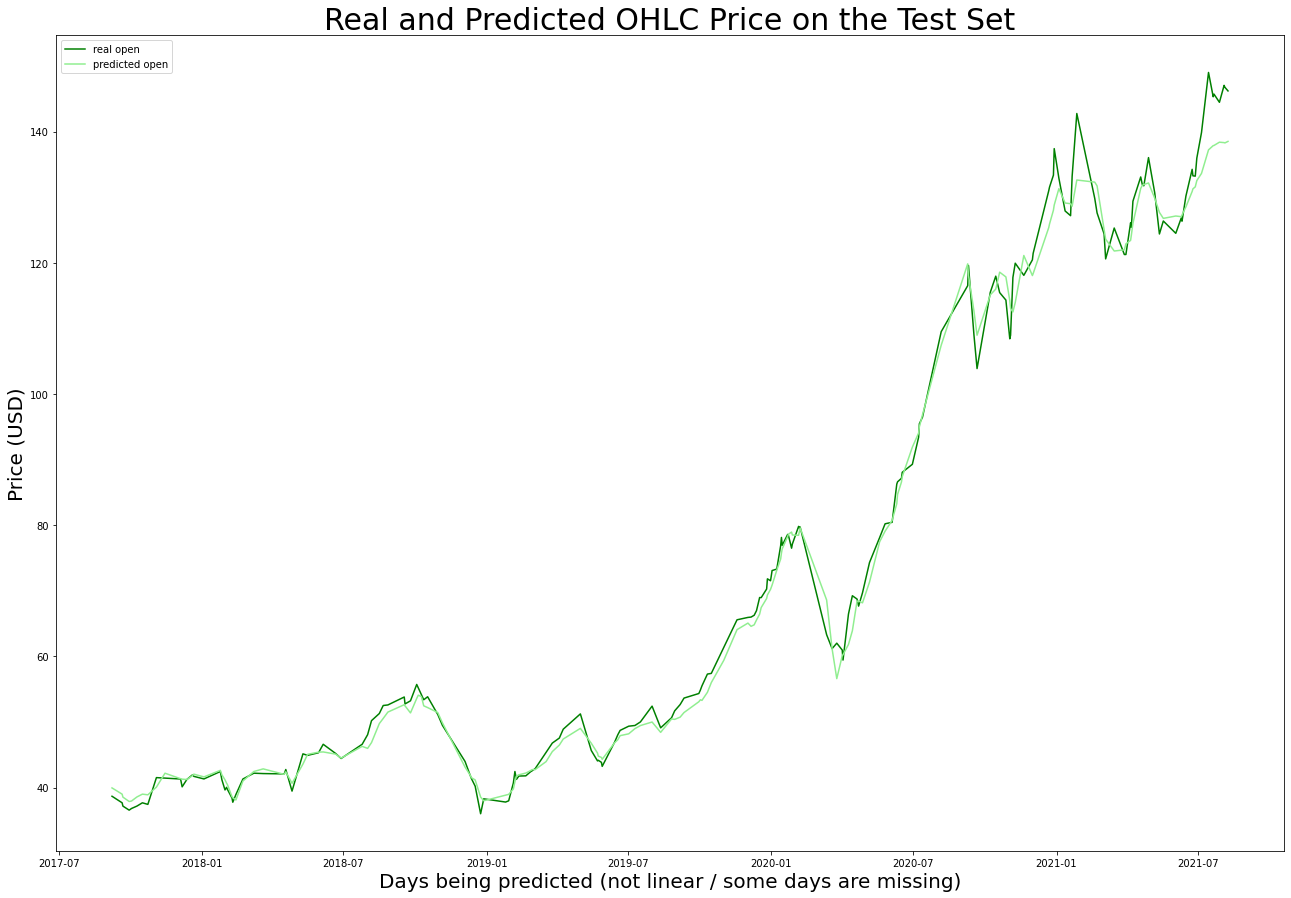

The MAE is:  2.3015695830178124
The MSE is:  11.434278261027341


In [ ]:
y_test_open_pred, y_test_high_pred, y_test_low_pred, y_test_close_pred = model.predict(X_test)
# display(model.predict(X_test))
# display(y_test_open_pred.shape, y_test_high_pred.shape, y_test_low_pred.shape, y_test_close_pred.shape)
preds_arr = np.hstack((y_test_open_pred, y_test_high_pred, y_test_low_pred, y_test_close_pred))
# df_preds = pd.DataFrame(data=)
# display(df_preds)
y_test_pred = y_normaliser.inverse_transform(preds_arr)

# display(y_test_pred.shape, unscaled_y_test.shape)

plt.gcf().set_size_inches(22, 15, forward=True)

start = 0
end = -1

# real values plotted
real_open = plt.plot(dates_test, unscaled_y_test[:,start], label='real open', color='green')
# real_high = plt.plot(unscaled_y_test[:,start + 1], label='real high', color='blue')
# real_low = plt.plot(unscaled_y_test[:,start + 2], label='real low', color='orange')
# real_close = plt.plot(unscaled_y_test[:,start + 3], label='real close', color='red')

# predicted values plotted
pred_open = plt.plot(dates_test, y_test_pred[:,start], label='predicted open', color='lightgreen')
# pred_high = plt.plot(y_test_pred[:,start + 1], label='predicted high', color='lightblue')
# pred_low = plt.plot(y_test_pred[:,start + 2], label='predicted low', color='moccasin')
# pred_close = plt.plot(y_test_pred[:,start + 3], label='predicted close', color='lightcoral')

# diff_1 = plt.plot(unscaled_y_test[:,start] - y_test_pred[:,start], label='open diff', color='yellow')

plt.legend()
plt.xlabel('Days being predicted (not linear / some days are missing)', fontsize=20)
plt.ylabel('Price (USD)', fontsize=20)
plt.title('Real and Predicted OHLC Price on the Test Set', fontsize=30)

plt.show()

from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(unscaled_y_test, y_test_pred)
mse = mean_squared_error(unscaled_y_test, y_test_pred)

print("The MAE is: ", mae)
print("The MSE is: ", mse)



In [ ]:
def percentage(a,b):
    s=0
    m=0
    for i in range(len(a)):
        if(b.iloc[i]>0):
            m+=1
            s+=(abs(a[i]-b.iloc[i])/b.iloc[i])
    return 100*s/m

In [ ]:
df_real = pd.DataFrame(data=unscaled_y_test)
df_pred = pd.DataFrame(data=y_test_pred)
display(df_real, df_real[[0]], df_pred[[0]])

,0,1,2,3
0,38.671576,38.707363,38.258831,38.473554
1,37.671922,37.757811,36.700898,37.235319
2,37.170902,37.170902,36.443231,36.595922
3,36.552978,36.772472,36.264295,36.770086
4,36.803488,36.848818,36.436073,36.696126
...,...,...,...,...
194,145.715639,147.972242,145.590827,146.579339
195,144.467518,146.329714,144.362676,145.421082
196,147.048632,147.567851,146.060120,146.729113
197,146.759068,147.617775,145.950286,146.838948


,0
0,38.671576
1,37.671922
2,37.170902
3,36.552978
4,36.803488
...,...
194,145.715639
195,144.467518
196,147.048632
197,146.759068


,0
0,39.943272
1,38.990219
2,38.539993
3,37.872955
4,37.940983
...,...
194,137.885818
195,138.384781
196,138.322235
197,138.273163


In [ ]:
percentage(df_real[0], df_pred[0])

2.3781393965150754

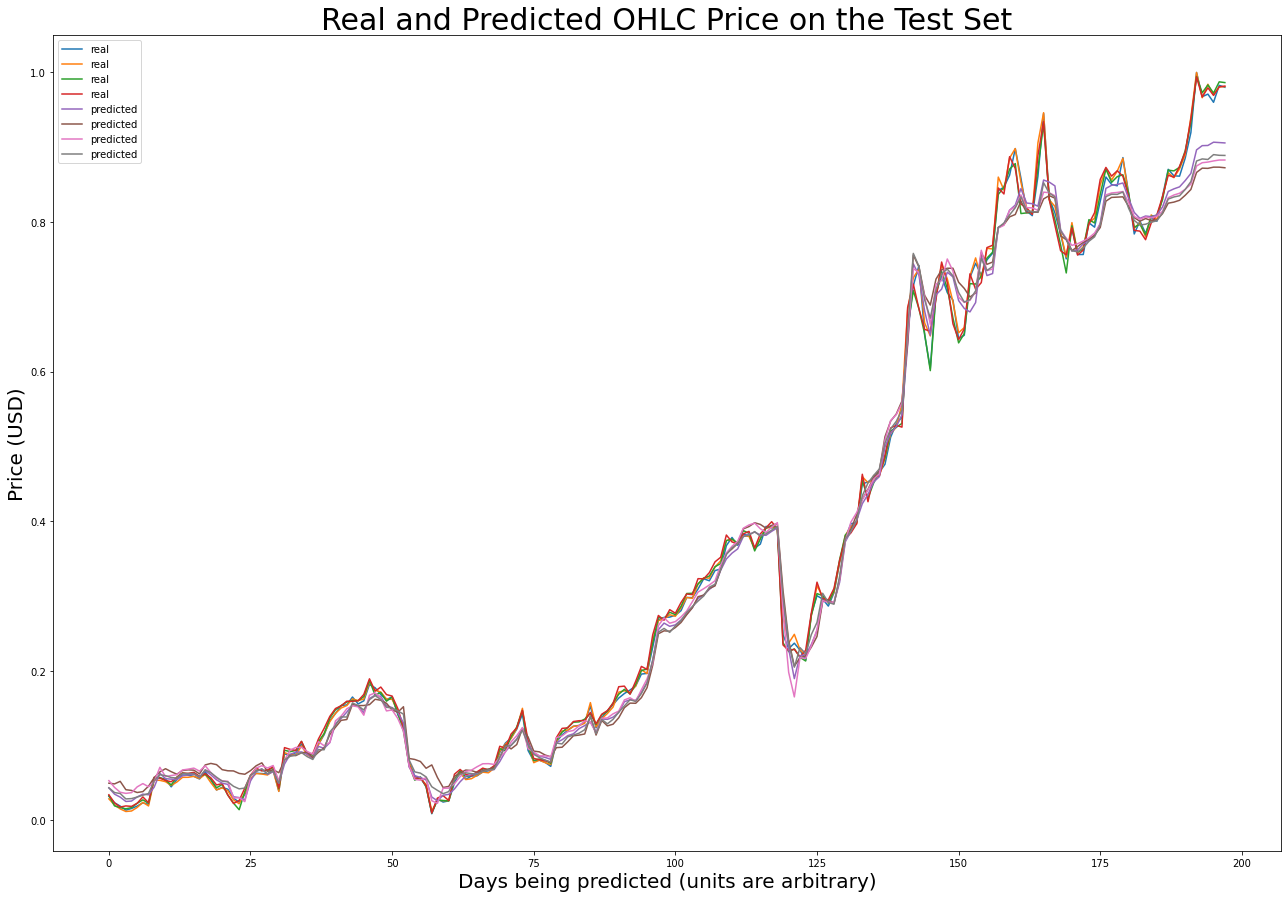

The MAE is:  0.020198218129337416
The MSE is:  0.0008805390037085656


In [ ]:
# Debugging to fix predictions. More specifically, checking if the normalization is the issue.
# Normalization is NOT the issue

y_test_open_pred, y_test_high_pred, y_test_low_pred, y_test_close_pred = model.predict(X_test)
preds_arr = np.hstack((y_test_open_pred, y_test_high_pred, y_test_low_pred, y_test_close_pred))
y_test_pred = preds_arr

plt.gcf().set_size_inches(22, 15, forward=True)

start = 0
end = -1

real = plt.plot(y_test[start:end], label='real')
pred = plt.plot(y_test_pred[start:end], label='predicted')

plt.legend()
plt.xlabel('Days being predicted (units are arbitrary)', fontsize=20)
plt.ylabel('Price (USD)', fontsize=20)
plt.title('Real and Predicted OHLC Price on the Test Set', fontsize=30)

plt.show()

from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)

print("The MAE is: ", mae)
print("The MSE is: ", mse)

